In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split


# Importing Dataset

In [3]:
df = pd.read_csv("diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Missing Values Analysis

In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
# Correcting missing values in blood pressure
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean()) # There are 35 records with 0 BloodPressure in dataset
# Correcting missing values in BMI
df['BMI'] = df['BMI'].replace(0, df['BMI'].median())
# Correct missing values in Insulin and SkinThickness

df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].median())

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Exploratory Data Analysis

## Correlation

<AxesSubplot: >

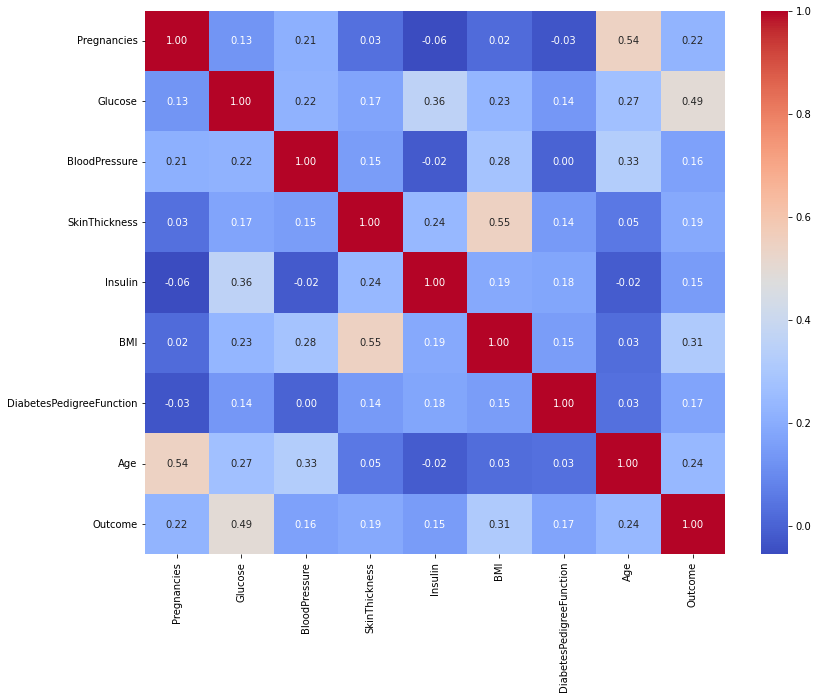

In [7]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

## Pregnancies

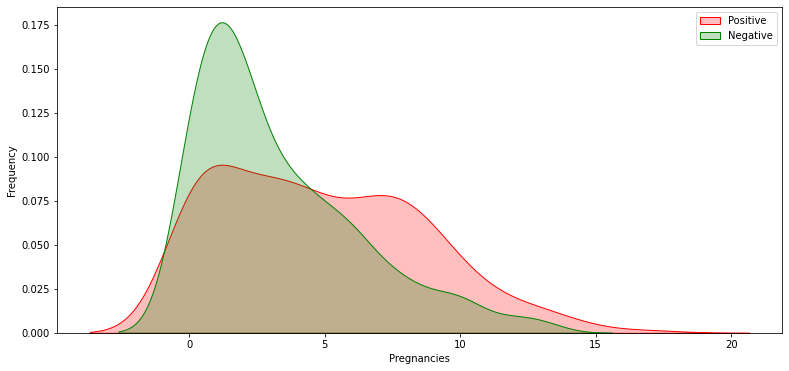

In [9]:
plt.figure(figsize=(13,6))
g = sns.kdeplot(df["Pregnancies"][df["Outcome"] == 1], 
     color="Red", fill = True)
g = sns.kdeplot(df["Pregnancies"][df["Outcome"] == 0], 
     ax =g, color="Green", fill= True)
g.set_xlabel("Pregnancies")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

## Glucose

<AxesSubplot: xlabel='Outcome', ylabel='Glucose'>

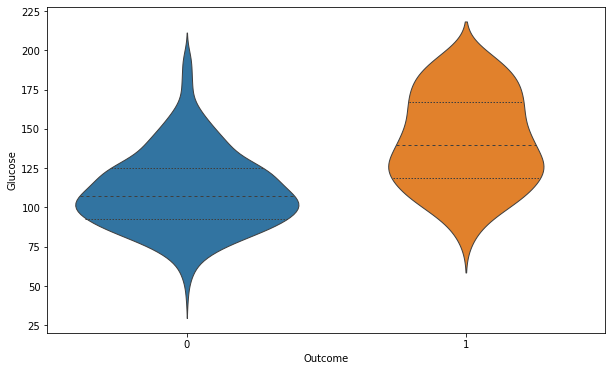

In [11]:
# Explore Gluecose vs Outcome
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x="Outcome", y="Glucose",
               split=True, inner="quart", linewidth=1)

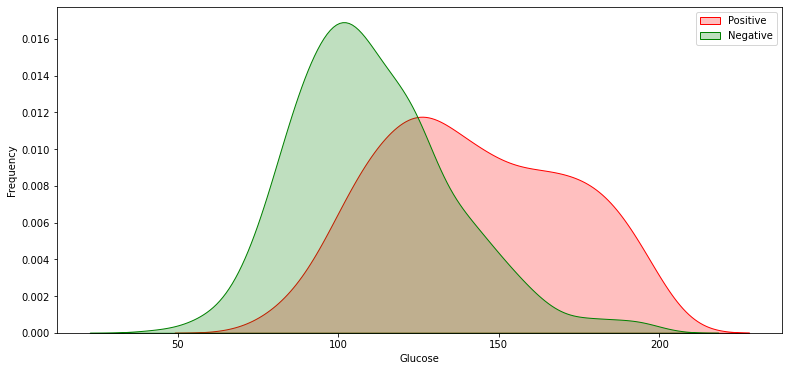

In [13]:
# Explore Glucose vs Outcome

plt.figure(figsize=(13,6))
g = sns.kdeplot(df["Glucose"][df["Outcome"] == 1], color="Red", fill = True)
g = sns.kdeplot(df["Glucose"][df["Outcome"] == 0], ax =g, color="Green", fill = True)
g.set_xlabel("Glucose")
g.set_ylabel("Frequency")
g.legend(["Positive","Negative"])

<AxesSubplot: xlabel='Glucose', ylabel='BMI'>

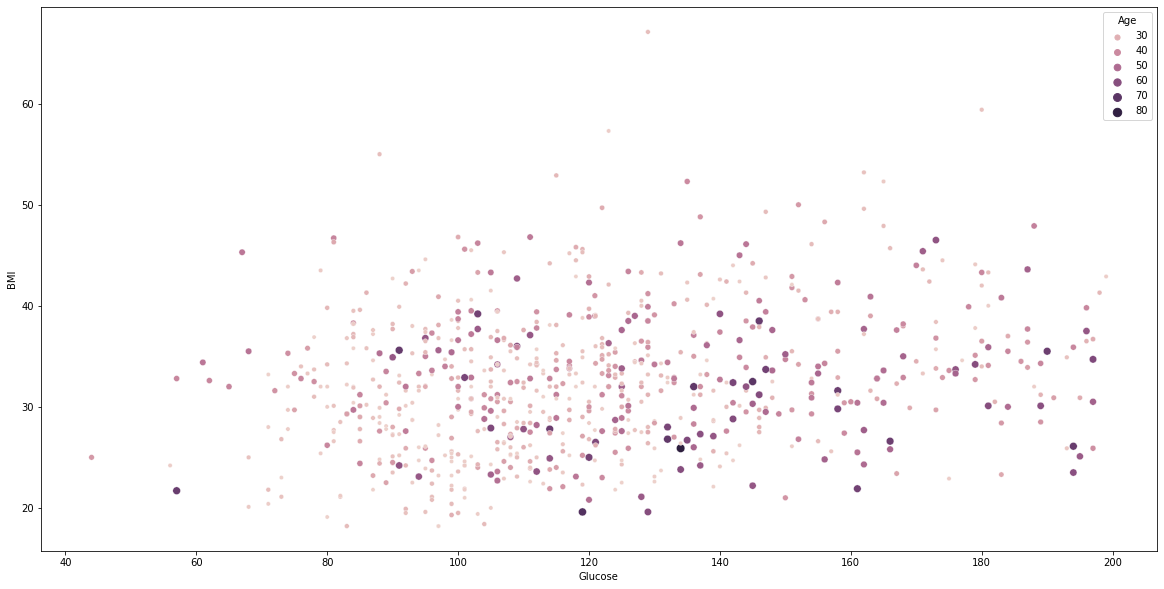

In [14]:
# Glucose vs BMI vs Age

plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x="Glucose", y="BMI", hue="Age", size="Age")

# Feature Engineering

## Outlier Detection

In [17]:
def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

outliers_to_drop = detect_outliers(df, 2 ,["Pregnancies", 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'SkinThickness', 'Insulin', 'Age'])

In [18]:
df.drop(df.loc[outliers_to_drop].index, inplace=True)

## Modeling

In [22]:
q  = QuantileTransformer()
X = q.fit_transform(df)
transformedDF = q.transform(X)
transformedDF = pd.DataFrame(X)
transformedDF.columns =['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
transformedDF.head()

C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (765). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.746728,0.812173,0.518979,0.804974,0.255890,0.593586,0.752618,0.889398,1.0
1,0.230366,0.091623,0.290576,0.645942,0.255890,0.214005,0.476440,0.556937,0.0
2,0.863220,0.956806,0.234293,0.358639,0.255890,0.077880,0.784031,0.582461,1.0
3,0.230366,0.125654,0.290576,0.358639,0.662958,0.285340,0.106675,0.000000,0.0
4,0.000000,0.723168,0.005236,0.804974,0.834424,0.929319,0.998691,0.604712,1.0


In [23]:
features = df.drop(["Outcome"], axis=1)
labels = df["Outcome"]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)

## Cross Validation 

In [24]:
def evaluate_model(models):
    
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        result.append(cross_val_score(estimator = model, X = x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

    cv_means = []
    cv_std = []
    for cv_result in result:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[
            "LogisticRegression",
            "DecisionTreeClassifier",
            "AdaBoostClassifier",
            "SVC",
            "RandomForestClassifier",
            "GradientBoostingClassifier",
            "KNeighborsClassifier"
        ]
    })

    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

,CrossValMeans,CrossValerrors,Models
0,0.747869,0.069754,LogisticRegression
1,0.710622,0.083627,DecisionTreeClassifier
2,0.703110,0.071917,AdaBoostClassifier
3,0.760901,0.050156,SVC
4,0.762893,0.061561,RandomForestClassifier
5,0.751747,0.098608,GradientBoostingClassifier
6,0.720021,0.090282,KNeighborsClassifier


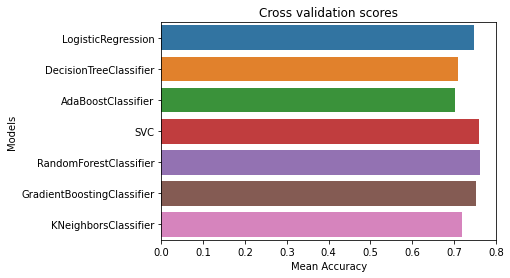

In [25]:
random_state = 30
models = [
    LogisticRegression(random_state = random_state, solver='liblinear'),
    DecisionTreeClassifier(random_state = random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.2),
    SVC(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    KNeighborsClassifier(),
]
evaluate_model(models)

## Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
def analyze_grid_result(grid_result):
    print("Tuned hyperparameters: (best parameters) ", grid_result.best_params_)
    print("Accuracy :", grid_result.best_score_)
    
    means = grid_result.cv_results_["mean_test_score"]
    stds = grid_result.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, grid_result.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    y_true, y_pred = y_test, grid_result.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

## Logistic Regression

In [29]:
model = LogisticRegression(solver='liblinear')
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = StratifiedKFold(n_splits = 50, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = cv, scoring = 'accuracy', error_score = 0)
logi_result = grid_search.fit(x_train, y_train)
analyze_grid_result(logi_result)

Tuned hyperparameters: (best parameters)  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.7883636363636363
0.788 (+/-0.260) for {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.260) for {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.788 (+/-0.260) for {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788 (+/-0.250) for {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.785 (+/-0.253) for {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.745 (+/-0.266) for {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.238) for {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.705 (+/-0.281) for {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.773 (+/-0.232) for {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696 (+/-0.264) for {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1    

## SVC

In [31]:
model = SVC()
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]
cv = StratifiedKFold(n_splits = 2, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = tuned_parameters, cv = cv, scoring = 'accuracy', error_score = 0)
scv_result = grid_search.fit(x_train, y_train)
analyze_grid_result(scv_result)

Tuned hyperparameters: (best parameters)  {'C': 10, 'kernel': 'linear'}
Accuracy : 0.7794524568170385
0.712 (+/-0.061) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.735 (+/-0.053) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.677 (+/-0.035) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.716 (+/-0.016) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.658 (+/-0.020) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.707 (+/-0.042) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.656 (+/-0.001) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.667 (+/-0.046) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.770 (+/-0.025) for {'C': 1, 'kernel': 'linear'}
0.779 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.778 (+/-0.005) for {'C': 100, 'kernel': 'linear'}
0.744 (+/-0.005) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.67      0

## Random Forest Classifier

In [32]:
model = RandomForestClassifier(random_state=42)
tuned_parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
cv = StratifiedKFold(n_splits = 2, random_state = 1, shuffle = True)
grid_search = GridSearchCV(estimator = model, param_grid = tuned_parameters, cv = cv, scoring = 'accuracy', error_score = 0)
grid_result = grid_search.fit(x_train, y_train)
analyze_grid_result(grid_result)

C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Pranav\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, expli

Tuned hyperparameters: (best parameters)  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
Accuracy : 0.7663648051875454
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
0.761 (+/-0.029) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 500}
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 200}
0.761 (+/-0.029) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 500}
0.751 (+/-0.018) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 200}
0.757 (+/-0.022) for {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}
0.751 (+/-0.025) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}
0.759 (+/-0.025) for {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}
0.751 (+/-

# Prediction

Till now logistic regression has given more accuracy. So, we will use only that model.

In [33]:
y_pred = logi_result.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       147
           1       0.68      0.58      0.62        83

    accuracy                           0.75       230
   macro avg       0.73      0.71      0.72       230
weighted avg       0.74      0.75      0.74       230



In [34]:
x_test['pred'] = y_pred
print(x_test)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
236            7    181.0           84.0             21    192.0  35.9   
715            7    187.0           50.0             33    392.0  33.9   
766            1    126.0           60.0             23     30.5  30.1   
499            6    154.0           74.0             32    193.0  29.3   
61             8    133.0           72.0             23     30.5  32.9   
..           ...      ...            ...            ...      ...   ...   
189            5    139.0           80.0             35    160.0  31.6   
351            4    137.0           84.0             23     30.5  31.2   
120            0    162.0           76.0             56    100.0  53.2   
108            3     83.0           58.0             31     18.0  34.3   
637            2     94.0           76.0             18     66.0  31.6   

     DiabetesPedigreeFunction  Age  pred  
236                     0.586   51     1  
715                     0